In [ ]:
from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import timedelta
from datetime import datetime

import plotly.graph_objects as go
import plotly.io as pio

import QuantLib as ql
from QuantLib import *
# from opt impor P_nss

from scipy.optimize import minimize_scalar
import pickle as pkl

In [ ]:
df = pd.read_excel("bond_data.xlsx")

############################################################################################

# Setup QuantLib evaluation
calendar = ql.Germany()
settlement_days = 2
ql.Settings.instance().evaluationDate = ql.Date(16, 5, 2025)
issue_date = ql.Date(1, 8, 2024)
face = 100
day_count = ql.Actual365Fixed()
compounding = ql.Compounded
frequency = ql.Semiannual

# Define bond 6955 (no contingent claim)
maturity_6955 = ql.Date(1, 2, 2034)
dates_6955 = [ql.Date(1, 2, y) if m == 2 else ql.Date(1, 8, y) for y in range(2027, 2034) for m in [2, 8]]
dates_6955.append(ql.Date(1, 2, 2034))
amounts_6955 = [1.5]*13 + [3.875, 103.875]
cashflows_6955 = [ql.SimpleCashFlow(a, d) for a, d in zip(amounts_6955, dates_6955)]
bond_6955 = ql.Bond(settlement_days, calendar, face, maturity_6955, issue_date, ql.Leg(cashflows_6955))

# Define bond 7177 (with contingent claim)
maturity_7177 = ql.Date(1, 2, 2035)
dates_7177 = [ql.Date(1, 2, y) if m == 2 else ql.Date(1, 8, y) for y in range(2027, 2035) for m in [2, 8]]
dates_7177.append(ql.Date(1, 2, 2035))
amounts_7177 = [1.5]*13 + [3.875, 3.875, 3.875, 103.875]
cashflows_7177 = [ql.SimpleCashFlow(a, d) for a, d in zip(amounts_7177, dates_7177)]
bond_7177 = ql.Bond(settlement_days, calendar, face, maturity_7177, issue_date, ql.Leg(cashflows_7177))

# Clean percentage strings
def clean_percent(x):
    try:
        return float(str(x).replace('%', '').strip())
    except:
        return None

df['Clean_Price_6955'] = df['Price XS2895056955'].apply(clean_percent)
df['Clean_Price_7177'] = df['Price XS2895057177'].apply(clean_percent)

# Compute yields
ytm_6955 = []
ytm_7177 = []

for p1, p2 in zip(df['Clean_Price_6955'], df['Clean_Price_7177']):
    try:
        y1 = bond_6955.bondYield(p1, day_count, compounding, frequency)
    except:
        y1 = None
    try:
        y2 = bond_7177.bondYield(p2, day_count, compounding, frequency)
    except:
        y2 = None
    ytm_6955.append(y1 * 100 if y1 is not None else None)
    ytm_7177.append(y2 * 100 if y2 is not None else None)

df['YTM XS2895056955'] = ytm_6955
df['YTM XS2895057177'] = ytm_7177

# Save result
df.to_excel("ytm_results.xlsx", index=False)
print("YTM calculations saved to ytm_results.xlsx")

YTM calculations saved to ytm_results.xlsx


In [ ]:
df = pd.read_excel("bond_data.xlsx")

calendar = Germany()
business_convention = ModifiedFollowing
date_generation = DateGeneration.Backward
month_end = False
settlement_days = 2
face = 100

def ql_to_datetime(d):
    return datetime(d.year(), d.month(), d.dayOfMonth())

# Define Bond w/o optional stepup
issue_date_1 = ql.Date(1, 8, 2024)
maturity_date_1 = ql.Date(1, 2, 2034)

# Define custom cashflow dates and amounts
cashflow_dates_1 = [ql.Date(1, 2, 2027), ql.Date(1, 8, 2027), 
                  ql.Date(1, 2, 2028), ql.Date(1, 8, 2028), 
                  ql.Date(1, 2, 2029), ql.Date(1, 8, 2029), 
                  ql.Date(1, 2, 2030), ql.Date(1, 8, 2030), 
                  ql.Date(1, 2, 2031), ql.Date(1, 8, 2031),
                  ql.Date(1, 2, 2032), ql.Date(1, 8, 2032), 
                  ql.Date(1, 2, 2033), ql.Date(1, 8, 2033), 
                  ql.Date(1, 2, 2034)  ]
cashflow_amounts_1 = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 3.875, 103.875]

cashflows_1 = [ql.SimpleCashFlow(amount, date) for amount, date in zip(cashflow_amounts_1, cashflow_dates_1)]

custom_leg_1 = ql.Leg(cashflows_1)

custom_bond_1 = ql.Bond(settlement_days, calendar, face, maturity_date_1, issue_date_1, custom_leg_1)

# Define Bond with optional stepup, assuming Peace is not met.
issue_date_2 = ql.Date(1, 8, 2024)
maturity_date_2 = ql.Date(1, 2, 2035)

# Define custom cashflow dates and amounts
cashflow_dates_2 = [ql.Date(1, 2, 2027), ql.Date(1, 8, 2027), 
                  ql.Date(1, 2, 2028), ql.Date(1, 8, 2028), 
                  ql.Date(1, 2, 2029), ql.Date(1, 8, 2029), 
                  ql.Date(1, 2, 2030), ql.Date(1, 8, 2030), 
                  ql.Date(1, 2, 2031), ql.Date(1, 8, 2031),
                  ql.Date(1, 2, 2032), ql.Date(1, 8, 2032), 
                  ql.Date(1, 2, 2033), ql.Date(1, 8, 2033), 
                  ql.Date(1, 2, 2034), ql.Date(1, 8, 2034), 
                  ql.Date(1, 2, 2035)  ]
cashflow_amounts_2 = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 3.875, 3.875, 3.875, 103.875]
cashflows_2 = [ql.SimpleCashFlow(amount, date) for amount, date in zip(cashflow_amounts_2, cashflow_dates_2)]
custom_leg_2 = ql.Leg(cashflows_2)
custom_bond_2 = ql.Bond(settlement_days, calendar, face, maturity_date_2, issue_date_2, custom_leg_2)

##########################################
# Clean percentage strings
def clean_percent(x):
    try:
        return float(str(x).replace('%', '').strip())
    except:
        return None
    
df['Clean_Price_6955'] = df['Price XS2895056955'].apply(clean_percent)
df['Clean_Price_7177'] = df['Price XS2895057177'].apply(clean_percent)

# Compute yields
ytm_6955 = []
ytm_7177 = []

day_count = ql.Actual365Fixed()
compounding = ql.Compounded
frequency = ql.Semiannual

for p1, p2 in zip(df['Clean_Price_6955'], df['Clean_Price_7177']):
    try:
        y1 = custom_bond_1.bondYield(p1, day_count, compounding, frequency)
    except:
        y1 = None
    try:
        y2 = custom_bond_2.bondYield(p2, day_count, compounding, frequency)
    except:
        y2 = None
    ytm_6955.append(y1 * 100 if y1 is not None else None)
    ytm_7177.append(y2 * 100 if y2 is not None else None)

df['YTM XS2895056955'] = ytm_6955
df['YTM XS2895057177'] = ytm_7177

df.to_excel("ytm_results.xlsx", index=False)
print("YTM calculations saved to ytm_results.xlsx")

YTM calculations saved to ytm_results.xlsx


In [4]:
df

,Date,Open,Close,High,Low,Volume,Volume nominal,Price XS2895056955,Price,Yield XS2895056955,...,Low.1,Volume.1,Volume nominal .1,Price XS2895057177,Price2,Yield XS2895057177,Clean_Price_6955,Clean_Price_7177,YTM XS2895056955,YTM XS2895057177
0,2025-06-12,37.77%,37.77%,37.77%,37.77%,NaN,NaN,37.77%,0.3777,0.762514,...,46.55%,NaN,NaN,46.55%,0.4655,0.729286,37.77,46.55,16.135680,12.721596
1,2025-06-11,37.25%,37.25%,37.25%,37.25%,NaN,NaN,37.25%,0.3725,0.764445,...,45.65%,NaN,NaN,45.65%,0.4565,0.732099,37.25,45.65,16.335182,12.971719
2,2025-06-10,36.81%,36.81%,36.81%,36.81%,NaN,NaN,36.81%,0.3681,0.766058,...,44.60%,NaN,NaN,44.60%,0.4460,0.735506,36.81,44.60,16.506514,13.270792
3,2025-06-09,36.27%,36.27%,36.27%,36.27%,NaN,NaN,36.27%,0.3627,0.768135,...,43.79%,NaN,NaN,43.79%,0.4379,0.738132,36.27,43.79,16.720041,13.507095
4,2025-06-06,35.84%,35.84%,35.84%,35.84%,NaN,NaN,35.84%,0.3584,0.769176,...,43.27%,NaN,NaN,43.27%,0.4327,0.739194,35.84,43.27,16.892712,13.661466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2024-09-12,31.91%,31.91%,31.91%,31.91%,NaN,NaN,31.91%,0.3191,0.716416,...,40.70%,NaN,NaN,40.70%,0.4070,0.681436,31.91,40.70,18.591258,14.457193
189,2024-09-11,32.17%,32.17%,32.17%,32.17%,NaN,NaN,32.17%,0.3217,0.714997,...,41.36%,NaN,NaN,41.36%,0.4136,0.678907,32.17,41.36,18.471560,14.247415
190,2024-09-10,33.48%,33.48%,33.48%,33.48%,1.004,3.0,33.48%,0.3348,0.708989,...,41.65%,NaN,NaN,41.65%,0.4165,0.677679,33.48,41.65,17.885077,14.156460
191,2024-09-09,31.86%,31.86%,31.86%,31.86%,NaN,NaN,31.86%,0.3186,0.715905,...,40.70%,NaN,NaN,40.70%,0.4070,0.680738,31.86,40.70,18.614406,14.457193


In [ ]:
c1 = 1.189463681
c2 = 3.072781177
add_face = 79.29757876

cashflow_dates_add = [
                  ql.Date(1, 2, 2030), ql.Date(1, 8, 2030), 
                  ql.Date(1, 2, 2031), ql.Date(1, 8, 2031),
                  ql.Date(1, 2, 2032), ql.Date(1, 8, 2032), 
                  ql.Date(1, 2, 2033), ql.Date(1, 8, 2033), 
                  ql.Date(1, 2, 2034), ql.Date(1, 8, 2034), 
                  ql.Date(1, 2, 2035)  ]
cashflow_amounts_add = [c1, c1, c1, c1, c1, c1, c1, c2, c2, c2, c2+add_face]
cashflows_add = [ql.SimpleCashFlow(amount, date) for amount, date in zip(cashflow_amounts_add, cashflow_dates_add)]
custom_leg_add = ql.Leg(cashflows_add)
custom_bond_add = ql.Bond(settlement_days, calendar, face, maturity_date_2, issue_date_2, custom_leg_add)

In [ ]:
bond_data = pd.read_excel('ytm_results.xlsx')
bond_data['Date'] = pd.to_datetime(bond_data['Date'])

peace_spread = -400
peace_scenario_yield = 0.12

prices_1 = {}
prices_2 = {}
prices_add = {}

# Define the days you want to price:
start_date = Date(6, 9, 2024)
end_date = Date(12, 6, 2025)

# Clean yield column: from '39.40%' to float 0.3940
bond_data['YTM XS2895056955'] = (
    bond_data['YTM XS2895056955']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float) / 100
)

# Clean yield column
bond_data['YTM XS2895057177'] = (
    bond_data['YTM XS2895057177']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float) / 100
)

# Clean price column
bond_data['Price XS2895056955'] = (
    bond_data['Price XS2895056955']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float) #/ 100
)

# Clean price column
bond_data['Price XS2895057177'] = (
    bond_data['Price XS2895057177']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float) #/ 100
)

In [ ]:
date = start_date

# Prepare containers for plotting
dates = []
yields_base  = []
yields_peace = []

while date < end_date:

    #try:
    Settings.instance().evaluationDate = date
    yield_value_s = bond_data.loc[bond_data['Date'] == ql_to_datetime(date), 'YTM XS2895056955']
    #print(date, yield_value_s)
    yield_value = yield_value_s.iloc[0]
    #print(yield_value)
    yield_curve = ql.FlatForward(2, calendar,
            yield_value, ql.Actual365Fixed())
    spot_curve_handle = YieldTermStructureHandle(yield_curve)
    bond_engine = DiscountingBondEngine(spot_curve_handle)

    custom_bond_1.setPricingEngine(bond_engine)
    custom_bond_2.setPricingEngine(bond_engine)

    prices_1[ql_to_datetime(date)] = custom_bond_1.cleanPrice()
    prices_2[ql_to_datetime(date)] = custom_bond_2.cleanPrice()

    # store for plot
    dates.append(ql_to_datetime(date))
    yields_base.append(yield_value * 100)    # % scale

    yield_peace = max(
        peace_scenario_yield,  # floor
        yield_value + peace_spread/10000)
    #print(date, yield_value, peace_spread, yield_peace)
    
    yield_curve_peace = ql.FlatForward(2, calendar,
            (yield_peace), ql.Actual365Fixed())
    
    peace_curve_handle = YieldTermStructureHandle(yield_curve_peace)
    bond_engine_peace = DiscountingBondEngine(peace_curve_handle)

    custom_bond_add.setPricingEngine(bond_engine_peace)
    prices_add[ql_to_datetime(date)]  = custom_bond_add.cleanPrice()
    
    #store for plot
    yields_peace.append(yield_peace * 100)   # % scale
    
    date = calendar.advance(date, 1, Days)

    #except (IndexError, KeyError) as e:
    #    print(f"No data for {ql_to_datetime(date)}. Skipping.")
    #    date = calendar.advance(date, 1, Days)

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=dates,
    y=yields_base,
    mode='lines',
    name='Market Implied Yield',
    line=dict(color='blue', width=2)
))
fig.add_trace(go.Scatter(
    x=dates,
    y=yields_peace,
    mode='lines',
    name='Peace Scenario Yield',
    line=dict(color='green', width=2, dash='dash')
))

fig.update_layout(
    template='plotly_white',
    #title='',
    xaxis=dict(
        #title='',
        tickangle=270,
        tickfont=dict(size=11),
        tickmode='auto',
        nticks=10,
        dtick="M1",
        tickformat='%b-%y'
    ),
    yaxis=dict(
        title='Yield (%)',
        range=[min(yields_base+yields_peace)-1, max(yields_base+yields_peace)+1],
        ticksuffix='%',
        tickfont=dict(size=10)
    ),
    legend=dict(
        x=0.98, y=0.98,
        xanchor='right', 
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black', 
        borderwidth=1,
        font=dict(size=10)
    ),
    margin=dict(l=40, r=40, t=50, b=40)
)

# fig.write_image("yield_curves.pdf", format='pdf')
fig.show()

In [9]:
bond_data.set_index('Date', inplace=True)

prices_1_df = pd.DataFrame.from_dict(prices_1, orient='index', columns=['TP XS2895056955']) # Step Up B Notes due 2034 (ISIN XS2895056955, CUSIP 903724CE0)
prices_2_df = pd.DataFrame.from_dict(prices_2, orient='index', columns=['TP no Peace XS2895057177'])
prices_add_df = pd.DataFrame.from_dict(prices_add, orient='index', columns=['TP_add Peace XS2895057177'])

bond_data = bond_data.join([prices_2_df, prices_1_df, prices_add_df])

keep = ['Yield XS2895056955',
        'Yield XS2895057177',
        'Price XS2895057177',
        'Price XS2895056955',
        'TP XS2895056955',
        'TP no Peace XS2895057177',
        'TP_add Peace XS2895057177',
        #'Probability'
    ]

bond_data = bond_data[keep]
bond_data['TP Peace XS2895057177'] = bond_data['Price XS2895056955'] + bond_data['TP_add Peace XS2895057177']

bond_data['Probability'] = 100 * ( 
    bond_data['Price XS2895057177'] - bond_data['Price XS2895056955'] + 
    bond_data['TP XS2895056955'] - bond_data['TP no Peace XS2895057177'] ) / (bond_data['TP_add Peace XS2895057177'])  

In [10]:
bond_data

,Yield XS2895056955,Yield XS2895057177,Price XS2895057177,Price XS2895056955,TP XS2895056955,TP no Peace XS2895057177,TP_add Peace XS2895057177,TP Peace XS2895057177,Probability
Date,,,,,,,,,
2025-06-12,0.762514,0.729286,46.55,37.77,NaN,NaN,NaN,NaN,NaN
2025-06-11,0.764445,0.732099,45.65,37.25,35.908411,33.908880,32.182116,69.432116,32.314629
2025-06-10,0.766058,0.735506,44.60,36.81,35.439522,33.433307,31.673500,68.483500,30.928741
2025-06-09,0.768135,0.738132,43.79,36.27,34.867901,32.854165,31.053314,67.323314,30.701185
2025-06-06,0.769176,0.739194,43.27,35.84,34.409635,32.390806,30.558520,66.398520,30.920441
...,...,...,...,...,...,...,...,...,...
2024-09-12,0.716416,0.681436,40.70,31.91,26.509857,24.725169,23.537386,55.447386,44.927196
2024-09-11,0.714997,0.678907,41.36,32.17,26.725582,24.942070,23.786917,55.956917,46.132549
2024-09-10,0.708989,0.677679,41.65,33.48,28.006513,26.219497,25.187196,58.667196,39.532051


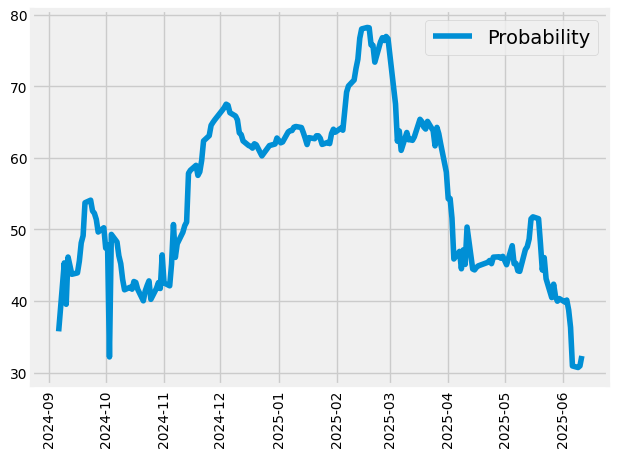

In [11]:
fig = plt.figure()
plt.style.use('fivethirtyeight')
plt.plot(bond_data['Probability'] , label='Probability')
plt.xticks(rotation=90, size=10)
plt.yticks(size=10)
plt.legend(labelcolor='k')
plt.tight_layout()
figname = 'Probability.pdf'
plt.savefig(figname)

plt.show()

In [12]:
line_width = 2  # change this to make the line thicker/thinner
vline_width = 2
vline_color = 'red'
vline_color2 = 'red'
election_date = '2024-11-05'
TrumpInauguration = '2025-01-20'
TrumpVanceZelensky_talk = '2025-02-28'
EasterTruce = '2025-04-19'
MassiveDroneAttack = '2025-05-18'

# Your data
x_values = bond_data.index  
y_values = bond_data['Probability']

# Build figure
fig = go.Figure()

# Main probability line
fig.add_trace(go.Scatter(
    x=x_values,
    y=y_values,
    mode='lines',
    name='Market Implied Probability',
    showlegend=True,
    line=dict(color='blue', width=line_width)
))

# Vertical line as a separate trace so it appears in the legend
fig.add_trace(go.Scatter(
    x=[election_date, election_date],
    y=[0, 100],
    mode='lines',
    name='(1) Trump Election (Nov 5, 2024)',
    showlegend=True,
    line=dict(color=vline_color, width=vline_width, dash='dash')
))

fig.add_trace(go.Scatter(
    x=[TrumpInauguration, TrumpInauguration],
    y=[0, 100],
    mode='lines',
    name='(2) Trump Inauguration (Jan 20, 2025)',
    showlegend=True,
    line=dict(color=vline_color, width=vline_width, dash='dash')
))

fig.add_trace(go.Scatter(
    x=[TrumpVanceZelensky_talk, TrumpVanceZelensky_talk],
    y=[0, 100],
    mode='lines',
    name="(3) Trump - Zelensky Oval Office argument (Feb 28, 2025)",
    showlegend=True,
    line=dict(color=vline_color, width=vline_width, dash='dash')
))

fig.add_trace(go.Scatter(
    x=[EasterTruce, EasterTruce],
    y=[0, 100],
    mode='lines',
    name="(4) Easter Truce (Apr 19, 2025)",
    showlegend=True,
    line=dict(color=vline_color, width=vline_width, dash='dash')
))

fig.add_trace(go.Scatter(
    x=[MassiveDroneAttack, MassiveDroneAttack],
    y=[0, 100],
    mode='lines',
    name="(5) Largest Russian drone attack since Feb-22 (May 18, 2025)",
    showlegend=True,
    line=dict(color=vline_color, width=vline_width, dash='dash')
))

annotations = [
    (election_date, "(1)"),
    (TrumpInauguration, "(2)"),
    (TrumpVanceZelensky_talk, "(3)"),
    (EasterTruce, "(4)"),
    (MassiveDroneAttack, "(5)")
]

for x, label in annotations:
    fig.add_trace(go.Scatter(
        x=[pd.to_datetime(x)-pd.Timedelta(days=2)],
        y=[2.5],  # Y-position for the annotation
        mode='text',
        text=[label],
        textposition='bottom left',
        showlegend=False,
        textfont=dict(size=7, color='black')
    ))

fig.update_layout(
    template='plotly_white',
    xaxis=dict(
        tickangle=270,
        tickfont=dict(size=11),
        tickmode='auto',
        nticks=10,
        tickformat='%b-%y' 

    ),
    yaxis=dict(
        range=[0, 100],  
        ticksuffix='%',
        tickfont=dict(size=10)
    ),
    legend=dict(
        # Put it inside the plotting area
        x=0.03,             # near the right
        y=1.08,             # near the top
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.95)',  # semi-transparent white bg
        bordercolor='black',
        borderwidth=1,
        font=dict(size=6)
    ),
    margin=dict(l=30, r=30, t=30, b=30)
)

# Export to PDF (with kaleido) and show
#fig.write_image("Probability.pdf", format='pdf')
fig.show()

In [ ]:
# Adjustable styling
line_width = 2

x_values = bond_data.index
cols = ['Price XS2895056955', 'Price XS2895057177']
colors = ['blue', 'green']  # you can choose any colors
names = [
    'Ukraine, Republik 0 24/34 - XS2895056955',
    'Ukraine, Republik 0 24/35 - XS2895057177'
]

fig = go.Figure()

for col, name, color in zip(cols, names, colors):
    fig.add_trace(go.Scatter(
        x=x_values,
        y=bond_data[col],
        mode='lines',
        name=name,                # <-- one string per trace
        line=dict(color=color, width=line_width),
        showlegend=True
    ))

fig.update_layout(
    template='plotly_white',
    xaxis=dict(
        tickangle=270,
        tickfont=dict(size=11),
        tickmode='auto',
        nticks=10,
        dtick="M1",            # one tick per month
        tickformat='%b-%y'     # e.g. “Jan-24”
    ),
    yaxis=dict(
        title=dict(
            text=(
                "Price" 
                "<br>"
                "<span style='font-size:12px; color:gray;'>(cent on the dollar)</span>"
            )
        ),
        tickfont=dict(size=10)
    ),
    legend=dict(
        x=0.99,
        y=1.11,
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black',
        borderwidth=1,
        font=dict(size=10)
    ),
    margin=dict(l=40, r=40, t=30, b=40)
)

#fig.write_image("Yields_Comparison.pdf", format='pdf')
fig.show()

In [14]:
line_width = 2

x_values = bond_data.index
cols = ['Price XS2895056955', 'Price XS2895057177']
colors = ['blue', 'green']
names = [
    'Ukraine, Republik 0 24/34 - XS2895056955',
    'Ukraine, Republik 0 24/35 - XS2895057177'
]

fig = go.Figure()

for col, name, color in zip(cols, names, colors):
    fig.add_trace(go.Scatter(
        x=x_values,
        y=(bond_data[col] / bond_data[col].iloc[-1]) * 100,
        mode='lines',
        name=name,
        line=dict(color=color, width=line_width),
        showlegend=True
    ))

fig.update_layout(
    template='plotly_white',
    xaxis=dict(
        tickangle=270,
        tickfont=dict(size=11),
        tickmode='auto',
        nticks=10,
        dtick="M1",
        tickformat='%b-%y'
    ),
    yaxis=dict(
        title=dict(
            text="Price<br><span style='font-size:10px; color:gray;'>(cent on the dollar, Index 100)</span>"
        ),
        tickfont=dict(size=10)
    ),
    legend=dict(
        x=0.99,
        y=1.11,
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black',
        borderwidth=1,
        font=dict(size=10)
    ),
    margin=dict(l=40, r=40, t=30, b=40)
)

fig.show()


In [15]:
line_width = 2

x_values = bond_data.index
cols = ['Price XS2895057177', 'TP no Peace XS2895057177', 'TP Peace XS2895057177']
colors = ['black', 'blue', 'green']  # you can choose any colors
names = [
    'Price XS2895057177', 
    'TP no Peace XS2895057177', 
    'TP Peace XS2895057177'
]

fig = go.Figure()

for col, name, color in zip(cols, names, colors):
    fig.add_trace(go.Scatter(
        x=x_values,
        y=bond_data[col],
        mode='lines',
        name=name,                # <-- one string per trace
        line=dict(color=color, width=line_width),
        showlegend=True
    ))

fig.update_layout(
    template='plotly_white',
    xaxis=dict(
        tickangle=270,
        tickfont=dict(size=11),
        tickmode='auto',
        nticks=10,
        dtick="M1",            # one tick per month
        tickformat='%b-%y'     # e.g. “Jan-24”
    ),
    yaxis=dict(
        title=dict(
            text=(
                "Price" 
                "<br>"
                "<span style='font-size:10px; color:gray;'>(cent on the dollar)</span>"
            )
        ),
        tickfont=dict(size=10)
    ),
    legend=dict(
        x=0.09,
        y=1.11,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black',
        borderwidth=1,
        font=dict(size=10)
    ),
    margin=dict(l=40, r=40, t=30, b=40)
)

#fig.write_image("Yields_Comparison.pdf", format='pdf')
fig.show()